# <center> Interactive analysis of molecular motors motion using a Jupyter notebook
## Ivan Unksov
### ivan.unksov@ftf.lth.se

We characterise the motion of molecular motors. In this notebook we calculate time averaged mean squared displacements (TA MSD) from a trajectories file. Then we get the anomaluos diffusion coefficients of the motors.

Before running the notebook, make sure the sample trajectories file `Vertical_in_channels_1000s&longer_140220.csv` and environment file `environment.yml` are in the working directory of the notebook. To install and activate the environment, in the prompt switch (if needed) to your working directory by typing 
   ```bash 
    cd "your path"
    ```  
and then run:
   ```bash
    conda env create -f environment.yml
    conda activate LMtracking
    ```

# Import trajectories data spreadsheet

In [1]:
import pandas as pd

df = pd.read_csv (r'Vertical_in_channels_1000s&longer_140220.csv',header=0,sep=',',engine='python') #change file path accordingly 
df = df.apply(pd.to_numeric,errors='coerce')
#print (df)

# Choose trajectories for analysis. Don't forget to press 'Enter' after you are done

In [2]:
print('Note that TA MSDs calculation is time-intense – for a quicker result choose not more than 2 trajectories when running the notebook.')
chosenTracksInput = input("Please enter trajectory numbers in range 1-45 separated by a comma or type 'all'. Press 'Enter': ");
chosenTracksInput = chosenTracksInput.replace(" ", ""); #remove whitespaces from user's input
chosenTracksList = chosenTracksInput.split(","); #split input to list, comma is separator
chosenTrackNum = chosenTracksList[0]; #1st track number from input
if chosenTrackNum.isdigit() == True: # check 1st track number is actual number
    print("You chose trajectory # " + chosenTrackNum)
    tracksDf = df.loc[:,['X'+chosenTrackNum, 'Y'+chosenTrackNum, 'Flag'+chosenTrackNum]]; #create dataframe w/ 1st chosen track
    for i in range (1,len(chosenTracksList)): #loop for other chosen track numbers
        chosenTrackNum = chosenTracksList[i];
        if chosenTrackNum.isdigit() == True:
            print("You chose trajectory # " + chosenTrackNum)
            dfChosenTrack = df.loc[:,['X'+chosenTrackNum, 'Y'+chosenTrackNum, 'Flag'+chosenTrackNum]];
            tracksDf = pd.concat([tracksDf, dfChosenTrack], axis=1); #add other chosen tracks to analysis dataframe
elif chosenTrackNum == 'all': # if all tracks are chosen, they're added to analysis dataframe
    print("You chose all trajectories")
    tracksDf = df.iloc[:,1:];
else:
    print("Trajectories not found. Please re-enter trajectory number or 'all'")  
#print(tracksDf)    

Note that TA MSDs calculation is time-intense – for a quicker result choose not more than 2 trajectories when running the notebook.
Please enter trajectory numbers in range 1-45 separated by a comma or type 'all'. Press 'Enter': 13
You chose trajectory # 13


# Create dafaframe for MSDs

In [3]:
import numpy as np

listOfFrames = []; #create empty list
for i in range (0, tracksDf.shape[0]): # loop for rows
    if np.isnan(df.iloc[i,0]) == False: # if frame exists in initial data, add zeros row for it in list
        listOfTracks = [df.iloc[i,0]];
        for j in range (1, int(tracksDf.shape[1] / 3) + 1):
            listOfTracks.extend(['NaN', 'NaN']);
        listOfFrames.append(listOfTracks);
listOfColNames = ['Frame'];
for trackNum in chosenTracksList:
    listOfColNames.extend(['TA MSD(x) track ' + trackNum, 'TA MSD(y) track ' + trackNum]);
dfMSD = pd.DataFrame(listOfFrames, columns = listOfColNames) #make MSD dataframe from list
print("Empty dataframe for MSD was created")
#print(dfMSD)

Empty dataframe for MSD was created


# Calculate MSDs

Time averaged mean squared displacement is calculated
<center> TA MSD $=\frac{1}{T-\tau}\sum_{t=0}^{T-\tau} (r(t+\tau)-r(t))^2$ </center>    
where $T$ -  total measurement time, $\tau$ - displacement time. Displacement time maximum is set to one-hundredth of $T$. 

In [4]:
mr = tracksDf.shape[0];
mc = tracksDf.shape[1];
delta_t = 1; #set delta t
colForMSD = 1;
#run loop for columns
for i in range (0, mc):
    if (i%3 == 0 or i%3 == 1):
        init = 1;   #init - index needed to prevent reading empty cells before the track. 1st row assumed to contain NaNs!!!
        rowForMSD=0; # rowForMSD - index of row in MSD column to which current MSD will be added 
        initPosition = tracksDf.iloc[init, i]; #read the initial coordinate of particle
        trackLength = 0;
        while (np.isnan(initPosition) == True and init < mr): #search for topmost non-empty cell in column i
            init += 1;
            initPosition = tracksDf.iloc[init, i];
        while np.isnan(tracksDf.iloc[init + trackLength + 1, i]) == False: #calculate track length
            trackLength += 1;
        #print(trackLength);  
        for tau in range (0, round(trackLength/100)+1): #loop for rows, set tau max here
            currentMSD = 0;
            #read coordinate of particle
            currentPosition = tracksDf.iloc[tau+init, i];
            coeff = 1 / (trackLength - tau); #coefficient for MSD
            if np.isnan(currentPosition) == False: #check for current position is a number
                for t in range (init, init + trackLength - tau + 1): # 1 added to run till t+tau = init + trackLength
                    positionDisplaced = tracksDf.iloc[t + tau, i];
                    positionNotDisplaced = tracksDf.iloc[t, i];
                    currentMSD = currentMSD + coeff * ((positionDisplaced - positionNotDisplaced) ** 2);
                #print(currentMSD)    
                dfMSD.iloc[rowForMSD, colForMSD] = currentMSD;
                rowForMSD += 1;
        colForMSD += 1;
#print(dfMSD)

# Saving MSDs dataframe as csv-file

In [5]:
dfMSD.to_csv('TAMSDs.csv', index=False)

# Generate plots
We plot $\log{\textrm{TA MSD}}$ vs. $\log{\tau}$. On that, linear fit is performed, and anomalous diffusion coefficient $\alpha$ is calculated 
<center>$\alpha=\frac{d(\log{\textrm{TA MSD}})}{d(\log{\tau})}$</center>  
We plot  $\alpha$ vs. trajectory number.

<Figure size 432x288 with 0 Axes>

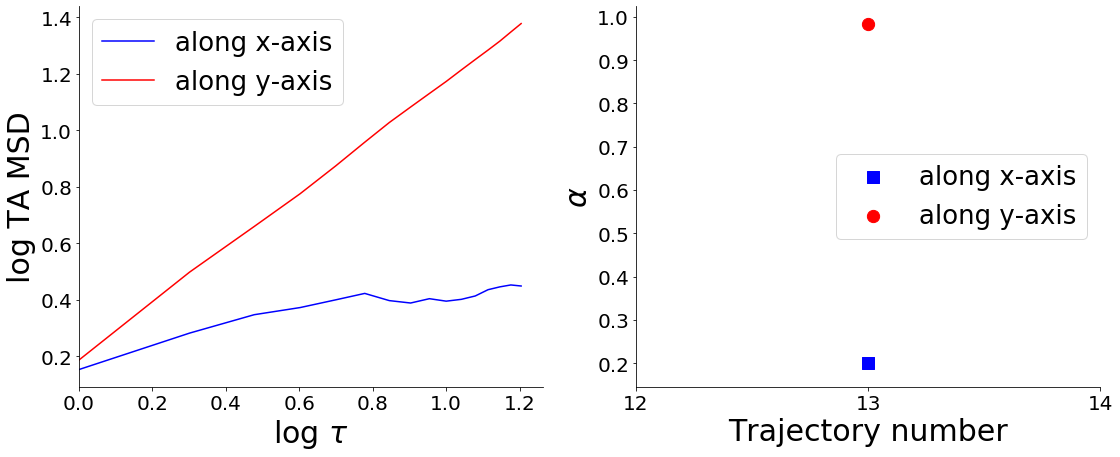

In [7]:
import matplotlib.pyplot as plt #for plotting
import math # for rounding 
from scipy import stats #for linear fit

#fps = float(input("Please enter number of frames per second for your data'. Press 'Enter': "));
fps = 1;
fig = plt.figure();
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18.3,7));
i = 1; #loop counter
while i < len(dfMSD.columns)-1: 
    logMSDx = np.log10(dfMSD.iloc[1:,i].astype(np.float64)).dropna(); # logs of sequetial columns pairs - to y-axis
    logMSDy = np.log10(dfMSD.iloc[1:,i+1].astype(np.float64)).dropna();
    logTime = np.log10(np.linspace(1/fps,int(len(logMSDx)/fps),num = len(logMSDx))); #log Time lag - to x-axis
    stringTrackName = dfMSD.iloc[1:,i].name;
    plottedTrackNum = [int(s) for s in stringTrackName.split() if s.isdigit()];
    slope_x, intercept_x, r_value_x, p_value_x, std_err_x = stats.linregress(logTime, logMSDx); #linear regression fit
    slope_y, intercept_y, r_value_y, p_value_y, std_err_y = stats.linregress(logTime, logMSDy);
    #print(slope_x, intercept, r_value, p_value, std_err)
    ax1.plot(logTime, logMSDx, 'b', logTime, logMSDy, 'r');
    ax2.scatter(plottedTrackNum, slope_x, s=150, c='b', marker="s", label='along x-axis');
    ax2.scatter(plottedTrackNum, slope_y, s=150, c='r', marker="o", label='along y-axis');
    i = i + 2

ax1.tick_params(axis='both', which='major', labelsize=20);  #set ticks labels font 
ax2.tick_params(axis='both', which='major', labelsize=20);
ax1.set_xlabel('log $\it{τ}$', fontsize=30); #set axial labels
ax1.set_ylabel('log TA MSD',fontsize=30); 
ax2.set_xlabel('Trajectory number',fontsize=30);
ax2.set_ylabel('$\it{α}$',fontsize=30);
ax1.spines['right'].set_visible(False) #remove top, right axis
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.set_xlim(left=logTime[0]); #set time axis limit as 1st element in logTime array
trackNumMin, trackNumMax = ax2.get_xlim()
trackNumStep = math.ceil((trackNumMax-trackNumMin)/5); #get number of ticks to spread evenly over x-axis
#print(trackNumStep)
ax2.set_xticks(np.arange(round(trackNumMin)-1, round(trackNumMax) + 2, trackNumStep)); #set trajectory num axis space=1 betw ticks
ax1.legend(['along x-axis','along y-axis'], fontsize=26);#set legends
ax2.legend(['along x-axis','along y-axis'],fontsize=26);
plt.savefig('TAMSD&alpha.png', dpi=300); #save as image
plt.show()